# Defining datasets for patches

In [1]:
#| default_exp nb_03_dataset

In [1]:
#|export
from pathlib import Path 

In [2]:
#|export
import pandas as pd

In [3]:
#| export
import matplotlib.pyplot as plt

In [4]:
#|export
from ml.nb_02_patching import *

## Data

In [5]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.shape

(1180, 95)

In [6]:
#| export
import torch.utils.data as data_utils

In [7]:
#| export
from PIL import Image

In [8]:
#| export
import torchvision.transforms as transforms

In [9]:
#| export
import numpy as np

In [10]:
#| export
import torch

In [11]:
#| export
import torchvision

In [12]:
#| export
import tqdm

## Dataset

In [13]:
#| export
class PatchedDataSet(data_utils.Dataset):

    """Returns a batch of N patches with the specified target in dataframe"""
    
    def __init__(self, 
                 img_path, # Path with images   
                 df, # pandas dataframe
                 y_col, # df column for target
                 stime_col, #df column with survival time
                 N, # number of patches
                 mean, #mean for normalization
                 std,  #std for normalization
                 trfms=None #list of transforms
                ):
        self.img_path = img_path
        self.df = df
        self.df.reset_index()
        self.y_col = y_col
        self.stime_col = stime_col
        self.N = N
        self.mean, self.std = mean, std
        self.trfm = trfms
        self.img_ids = self.get_img_ids()
        
    def get_img_ids(self):
        return self.img_path.str()+"/"+self.df.TMA_ID+"_"+self.df.TMASpot
                
        
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        patch_paths = [img_id+"_"+str(i)+".png" for i in range(self.N)]
        patches = []
        
        transform = transforms.Compose([
            transforms.ToTensor()
            ])
        
        for p in patch_paths:
            img = Image.open(p)
            img = transform(img)
            
            if self.trfm is not None: 
                img = self.trfm(img)
            
            img = transforms.Normalize(self.mean, self.std)(img)
            patches.append(img)
            
        patches = torch.stack(patches, dim=0)
        
        return patches.clone().detach(), self.df.iloc[idx][self.y_col], self.df.iloc[idx][self.stime_col]
    
    def __len__(self):
        return len(self.img_ids)

In [14]:
#| export
p_outx = Path("/media/dimi/TOSHIBA EXT/patched_images")
p_outy = Path("/media/dimi/TOSHIBA EXT/patched_masks")

In [15]:
#| export
mean_img, std_img = [0.8868493, 0.7803772, 0.87521], [0.07292725, 0.09504553, 0.05757239]
mean_mask, std_mask = [0.04432359, 0.04432359, 0.04432359], [0.02483896, 0.02483896, 0.02483896]

## Test

In [16]:
ds = PatchedDataSet(p_outx, df, "event_10y_dom", 32, mean_img, std_img)

TypeError: PatchedDataSet.__init__() missing 1 required positional argument: 'std'

In [124]:
dl = data_utils.DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)

In [126]:
dataiter = iter(dl)

In [127]:
images, labels = dataiter.next()

In [128]:
len(ds)

1180

In [132]:
images.shape

(torch.Size([1, 32, 3, 128, 128]), tensor([0]))

In [138]:
images = torch.squeeze(images)
images.shape

torch.Size([32, 3, 128, 128])

In [133]:
labels

tensor([0])

In [139]:
grid_img = torchvision.utils.make_grid(images, nrow=6)

In [140]:
grid_img.shape

torch.Size([3, 782, 782])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


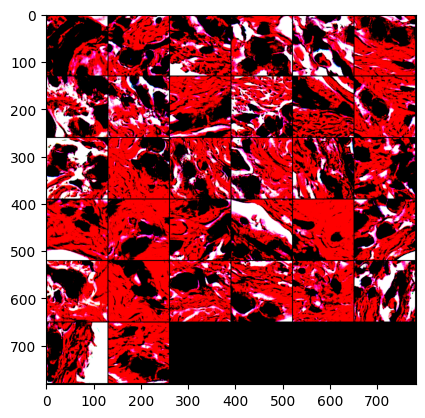

In [142]:
plt.imshow(grid_img.permute(1, 2, 0));

In [144]:
#| hide
import nbdev; nbdev.nbdev_export()

## Tmp

In [17]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
from sksurv.metrics import concordance_index_censored as cindex

In [20]:
df = df[~pd.isnull(df.stime_10y_dom)]
df.shape

(1166, 95)

In [21]:
cindex(df.event_10y_dom.astype(bool), df.stime_10y_dom, (1./(0.05+df.stime_10y_dom)))

(0.999935869608114, 101343, 0, 13, 13)

In [22]:
cuda = True

In [59]:
#| export
import tqdm

In [60]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    predictions = []
    labels = []
    stime_labels = []
    for batch_idx, (data, label, stime) in tqdm.notebook.tqdm(enumerate(train_loader)):
        #print('epoch = ', epoch)
        #print('batch_idx = ', batch_idx)
        bag_label = label
        data = torch.squeeze(data)
        if cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)
        data, bag_label = data.to(device), bag_label.to(device)

        # Reset gradients
        optimizer.zero_grad()
        # Calculate loss
        loss, attention_weights = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        # Calculate error
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        train_error += error
        
        # Keep track of predictions and labels to calculate accuracy after each epoch
        Y_prob, _, _ = model(data)
        predictions.append(Y_prob.cpu().detach().numpy().item(0)) 
        labels.append(bool(bag_label.cpu().detach().numpy()[0]))
        stime_labels.append(stime.cpu().detach().numpy()[0])
        # Backward pass
        loss.backward()
        # Update model weights
        optimizer.step()

    # Calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)
    cind,_,_,_,_ = cindex(labels, stime_labels, predictions)

    print('Train Set, Epoch: {}, Loss: {:.4f}, Error: {:.4f}, C-Index: {:.4f}'.format(epoch, 
                                                                                       train_loss.cpu().numpy()[0], 
                                                                                       train_error, 
                                                                                       cind)
         )

In [46]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.
    test_error = 0.
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            bag_label = label
            data = torch.squeeze(data)

            data, bag_label = Variable(data), Variable(bag_label)
            data, bag_label = data.to(device), bag_label.to(device)

            loss, attention_weights = model.calculate_objective(data, bag_label)
            test_loss += loss.data[0]
            error, predicted_label = model.calculate_classification_error(data, bag_label)
            test_error += error

    test_error /= len(test_loader)
    test_loss /= len(test_loader)

    print('\nTest Set, Loss: {:.4f}, Error: {:.4f}'.format(test_loss.cpu().numpy()[0], test_error))

In [23]:
#transform_train = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
#                                      transforms.RandomVerticalFlip(0.5),
#                                      transforms.ToTensor()])

In [24]:
#| export
def split_ds(ds, 
             n=0.8 #percentage training
            ):
    train_size = int(n * len(ds))
    return torch.utils.data.random_split(ds, [train_size, len(ds) - train_size])

In [25]:
ds = PatchedDataSet(p_outx, df, "event_10y_dom", "stime_10y_dom", 32, mean_img, std_img)
ds_train, ds_test = split_ds(ds)
print(len(ds_train), len(ds_test))

932 234


In [33]:
_, ds_sample = split_ds(ds, n=0.99)
len(ds_sample)

12

In [34]:
dl = data_utils.DataLoader(ds_sample, batch_size=1, shuffle=True, num_workers=0)

In [35]:
device = torch.device("cuda")
model = Attention().to(device)

In [61]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(1, 10 + 1):
    train(model, device, dl, opt, epoch)

0it [00:00, ?it/s]

Train Set, Epoch: 1, Loss: 0.9600, Error: 0.0833, C-Index: 0.3182


0it [00:00, ?it/s]

Train Set, Epoch: 2, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 3, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 4, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 5, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 6, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 7, Loss: 0.9594, Error: 0.0833, C-Index: 0.5000


0it [00:00, ?it/s]

Train Set, Epoch: 8, Loss: 0.9594, Error: 0.0833, C-Index: 0.4091


0it [00:00, ?it/s]

Train Set, Epoch: 9, Loss: 0.9594, Error: 0.0833, C-Index: 0.4091


0it [00:00, ?it/s]

Train Set, Epoch: 10, Loss: 0.9594, Error: 0.0833, C-Index: 0.2727


In [29]:

import torch.nn.functional as F
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 512 # 512 node fully connected layer
        self.D = 128 # 128 node attention layer
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 36, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(36, 48, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(48 * 30 * 30, self.L),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout()
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 48 * 30 * 30)
        H = self.feature_extractor_part2(H)

        A = self.attention(H) # NxK
        A = torch.transpose(A, 1, 0) # KxN
        A = F.softmax(A, dim=1) # softmax over N

        M = torch.mm(A, H)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A.byte()

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))
        return neg_log_likelihood, A